In [1]:
from pathlib import Path
from omegaconf import OmegaConf
import numpy as np
import torch
import matplotlib.pyplot as plt
import wandb

from wyckoff_transformer.tokenization import load_tensors_and_tokenisers
from wyckoff_transformer.generator import WyckoffGenerator
from cascade_transformer.model import CascadeTransformer
from cascade_transformer.dataset import AugmentedCascadeDataset, TargetClass, batched_bincount

device = torch.device("cpu")
run_id = "1okrz6qt"
wandb_run = wandb.Api().run(f"WyckoffTransformer/{run_id}")
config = OmegaConf.create(dict(wandb_run.config))

# The start tokens will be sampled from the train+validation datasets,
# to preserve the sanctity of the test dataset and ex nihilo generation.
tensors, tokenisers = load_tensors_and_tokenisers(config.dataset, config.tokeniser.name)    
generation_size = 15000 #len(next(iter(tensors["test"].values())))*2
del tensors["test"]

max_start = len(tokenisers[config.model.start_token])
start_counts = torch.bincount(tensors["train"][config.model.start_token], minlength=max_start) + \
                torch.bincount(tensors["val"][config.model.start_token], minlength=max_start)
underrepresented = start_counts < 1000
start_counts[underrepresented] = 0
print(f"Excluded {underrepresented.sum()} underrepresented start tokens.")
start_distribution = torch.distributions.Categorical(probs=start_counts.float())

model = CascadeTransformer.from_config_and_tokenisers(config, tokenisers, device)
model.load_state_dict(torch.load(Path("runs", run_id, "best_model_params.pt"), map_location=device))
# We need to grab any tensor from the train dataset
max_sequence_len = tensors["train"][config.model.cascade_order[0]].size(1)

masks_dict = {field: tokenisers[field].mask_token for field in config.model.cascade_order}
pad_dict = {field: tokenisers[field].pad_token for field in config.model.cascade_order}
stops_dict = {field: tokenisers[field].stop_token for field in config.model.cascade_order}
num_classes_dict = {field: len(tokenisers[field]) for field in config.model.cascade_order}

generator = WyckoffGenerator(model, config.model.cascade_order, masks_dict, max_sequence_len)
if "augmented_token_fields" in config.tokeniser and len(config.tokeniser.augmented_token_fields) > 0:
    augmented_field = config.tokeniser.augmented_token_fields[0]
else:
    augmented_field = None
validation_dataset = AugmentedCascadeDataset(
    data=tensors["val"],
    cascade_order=config.model.cascade_order,
    masks=masks_dict,
    pads=pad_dict,
    stops=stops_dict,
    num_classes=num_classes_dict,
    start_field=config.model.start_token,
    augmented_field=augmented_field,
    dtype=torch.long,
    device=device)

Excluded 168 underrepresented start tokens.


In [2]:
stops_dict

{'elements': 88}

In [3]:
start_counts = torch.bincount(tensors["train"][config.model.start_token], minlength=max_start)
underrepresented = start_counts < 100

Total 2571; At max element count: 1653


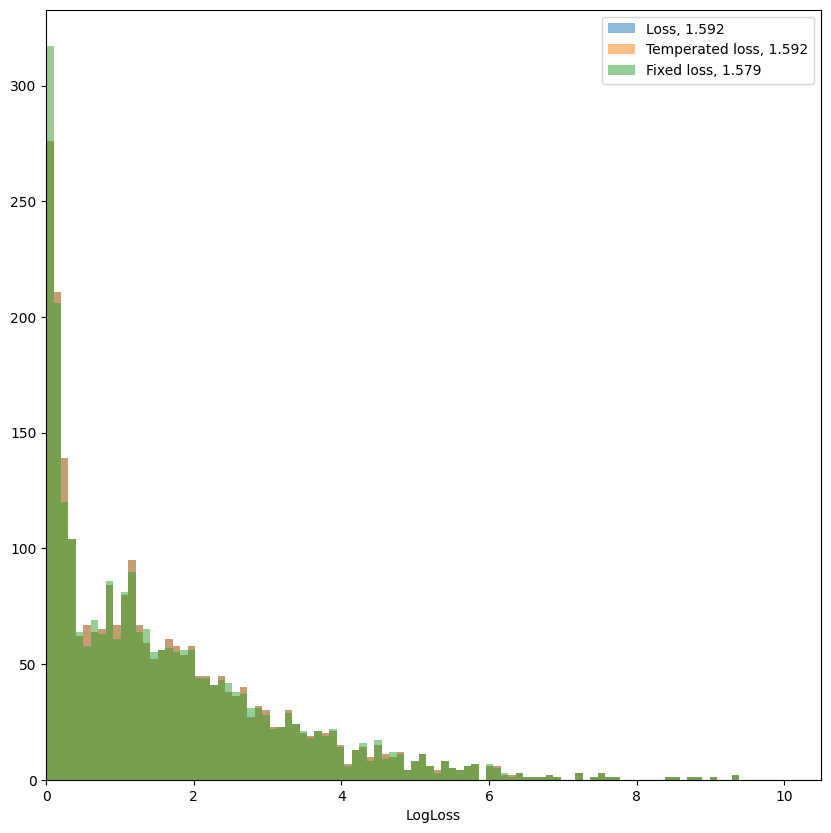

In [4]:
known_seq_len = 4
known_cascade_len = 0
with torch.no_grad():
    start_tokens, masked_data, target = validation_dataset.get_masked_multiclass_cascade_data(
                            known_seq_len, known_cascade_len,
                            target_type=TargetClass.NextToken, multiclass_target=True)
    selected = ~underrepresented[start_tokens]
    start_tokens = start_tokens[selected]
    for i in range(len(masked_data)):
        masked_data[i] = masked_data[i][selected]
    target = target[selected]
    logits = model(start_tokens, masked_data, None, known_cascade_len)
    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")
    loss = loss_fn(logits, target)

    logits_temperated = logits / 1
    loss_temperated = loss_fn(logits_temperated, target)
    element_present = batched_bincount(masked_data[0], dim=1, max_value=num_classes_dict["elements"], dtype=torch.bool)
    element_counts = element_present.sum(dim=1)
    # at max element count
    # ternary + MASK
    at_max_element_count = element_counts == 4
    print(f"Total {target.size(0)}; At max element count: {at_max_element_count.sum()}")
    fixed_logits = logits.clone()

    element_present |= ~at_max_element_count[:, None]
    element_present[:, tokenisers["elements"].stop_token] = True
    fixed_logits[~element_present] -= 1e7
    fixed_loss = loss_fn(fixed_logits, target)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    bins = np.linspace(0, 10, 100)
    ax.hist(loss.cpu().numpy(), bins=bins, alpha=0.5, label=f"Loss, {loss.mean().item():.3f}")
    ax.hist(loss_temperated.cpu().numpy(), bins=bins, alpha=0.5, label=f"Temperated loss, {loss_temperated.mean().item():.3f}")
    ax.hist(fixed_loss.cpu().numpy(), bins=bins, alpha=0.5, label=f"Fixed loss, {fixed_loss.mean().item():.3f}")
    ax.legend()
    ax.set_xlabel("LogLoss")
    ax.set_xlim(0)

In [5]:
#generator.calibrate(validation_dataset)
generation_size = 10000
generated_elements = generator.generate_tensors(start_distribution.sample((generation_size,)))[0]

In [6]:
counts = batched_bincount(generated_elements, dim=1, max_value=num_classes_dict["elements"], dtype=torch.bool)
counts[:, masks_dict["elements"]] = False
counts[:, stops_dict["elements"]] = False
counts[:, pad_dict["elements"]] = False
c = counts.sum(1)

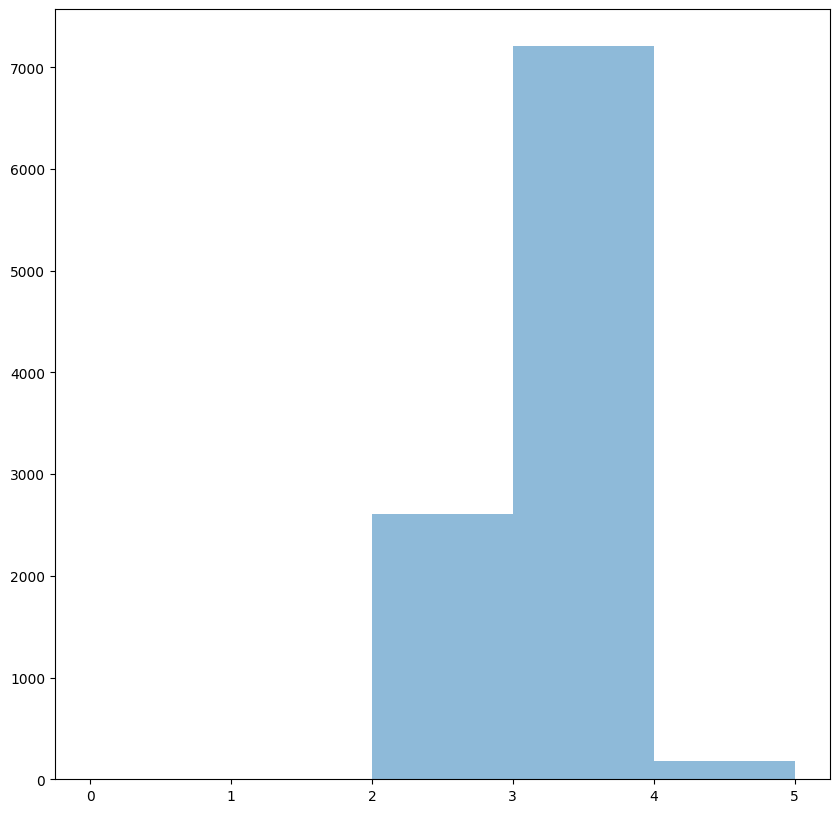

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(c.cpu().numpy(), bins=np.arange(0, c.max().item()+1), alpha=0.5);

In [8]:
irl_e=[[tokenisers["elements"].to_token[e] for e in s if e != tokenisers["elements"].stop_token] for s in generated_elements.numpy()]

In [9]:
irl_e

[[Element Ge, Element Mn],
 [Element Co, Element Sm, Element Co, Element Co],
 [Element S,
  Element S,
  Element Mo,
  Element S,
  Element S,
  Element S,
  Element Mo,
  Element Cr],
 [Element Nb, Element Se, Element Na],
 [Element Mn, Element Ru, Element Ti],
 [Element Br, Element Rb, Element Cr],
 [Element Y, Element Y, Element I, Element O, Element O],
 [Element Ho, Element Hg, Element Ac],
 [Element Li, Element Ga, Element Au],
 [Element Cr, Element O, Element O, Element O, Element O],
 [Element Sm, Element Mg],
 [Element Si, Element Tc, Element Al],
 [Element V,
  Element Ti,
  Element Cr,
  Element Cr,
  Element Cr,
  Element Cr,
  Element V,
  Element Ti],
 [Element N, Element Yb, Element Cd],
 [Element Na,
  Element Hg,
  Element Rb,
  Element Br,
  Element Br,
  Element Br,
  Element Br],
 [Element K, Element Cu, Element S, Element S],
 [Element Ga,
  Element Ga,
  Element Ga,
  Element Ho,
  Element Ho,
  Element Co,
  Element Co],
 [Element Ni, Element Ca, Element Si],
 [

In [10]:
tokenisers["elements"].mask_token

89